In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math, os, joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X = np.load("/content/drive/MyDrive/Combined_Embeddings/X_vit_embeddings_Combined.npy")
y = np.load("/content/drive/MyDrive/Combined_Embeddings/y_labels_Combined.npy")

print("Loaded dataset:", X.shape, y.shape)

Loaded dataset: (105046, 768) (105046,)


In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (84036, 768) (84036,)
Test: (21010, 768) (21010,)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

os.makedirs("models_resnet", exist_ok=True)
joblib.dump(scaler, "models_resnet/resnet_scaler.joblib")
print("Scaler saved!")


Scaler saved!


In [ ]:
input_dim = X_train.shape[1]
inputs = layers.Input(shape=(input_dim,))

x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.35)(x)

# ---- Residual Block 1 ----
x1 = layers.Dense(512, activation='relu')(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Dropout(0.3)(x1)
x = layers.add([x, layers.Dense(1024, activation='relu')(x1)])

# ---- Residual Block 2 ----
x2 = layers.Dense(512, activation='relu')(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Dropout(0.3)(x2)
x = layers.add([x, layers.Dense(1024, activation='relu')(x2)])

# ---- Final Layers ----
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │    787,456 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │    525,312 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1024)      │          0 │ dropout[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024)      │    525,312 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1024)      │          0 │ add[0][0],        │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    262,400 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        257 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,159,553 (12.05 MB)

 Trainable params: 3,154,945 (12.04 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:
def cosine_lr_schedule(epoch):
    return float(1e-4 * (0.5 * (1 + math.cos(math.pi * epoch / 20))))

cosine_lr = callbacks.LearningRateScheduler(cosine_lr_schedule)

early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "models_resnet/best_resnet_classifier.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=50,
    batch_size=64,
    callbacks=[cosine_lr, early_stop, checkpoint],
    verbose=1
)

Epoch 1/50
1116/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6984 - loss: 0.6486
Epoch 1: val_accuracy improved from -inf to 0.82247, saving model to models_resnet/best_resnet_classifier.keras
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 93s 79ms/step - accuracy: 0.6985 - loss: 0.6485 - val_accuracy: 0.8225 - val_loss: 0.4050 - learning_rate: 1.0000e-04
Epoch 2/50
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7935 - loss: 0.4587
Epoch 2: val_accuracy improved from 0.82247 to 0.84198, saving model to models_resnet/best_resnet_classifier.keras
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 89s 80ms/step - accuracy: 0.7935 - loss: 0.4587 - val_accuracy: 0.8420 - val_loss: 0.3672 - learning_rate: 9.9384e-05
Epoch 3/50
1116/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8223 - loss: 0.4063
Epoch 3: val_accuracy improved from 0.84198 to 0.85047, saving model to models_resnet/best_resnet_classifier.keras
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 139s 77ms/step - accuracy: 0.8223 - loss: 0.4063 - val_accurac

In [ ]:
model.save("models_resnet/final_resnet_classifier.keras")
print("Model saved!")

Model saved!


In [ ]:
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype("int32").reshape(-1)

657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc*100:.2f}% \n")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))


Test Accuracy: 88.41% 

              precision    recall  f1-score   support

        Real       0.88      0.90      0.89     10902
        Fake       0.89      0.87      0.88     10108

    accuracy                           0.88     21010
   macro avg       0.88      0.88      0.88     21010
weighted avg       0.88      0.88      0.88     21010



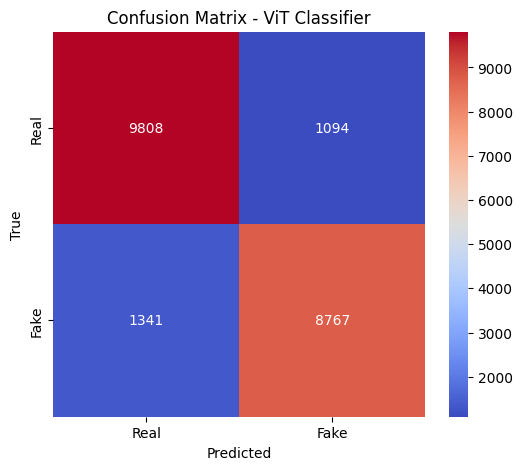

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix - ViT Classifier")
plt.show()

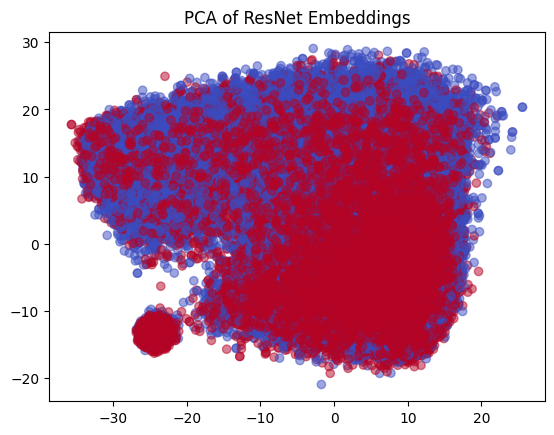

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='coolwarm', alpha=0.5)
plt.title("PCA of ResNet Embeddings")
plt.show()

In [ ]:
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers
import math

input_dim = X_train.shape[1]
inputs = layers.Input(shape=(input_dim,))

x = layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.35)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: weights[0], 1: weights[1]}
print(class_weights)


{0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: weights[0], 1: weights[1]}
print(class_weights)

{0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, cosine_lr]
)

Epoch 1/50
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6388 - loss: 0.7455
Epoch 1: val_accuracy did not improve from 0.81042
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 209s 181ms/step - accuracy: 0.6388 - loss: 0.7455 - val_accuracy: 0.7609 - val_loss: 0.5054 - learning_rate: 1.0000e-04
Epoch 2/50
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7481 - loss: 0.5422
Epoch 2: val_accuracy did not improve from 0.81042
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 186s 166ms/step - accuracy: 0.7481 - loss: 0.5422 - val_accuracy: 0.7890 - val_loss: 0.4653 - learning_rate: 9.9384e-05
Epoch 3/50
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7875 - loss: 0.4706
Epoch 3: val_accuracy did not improve from 0.81042
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 180s 169ms/step - accuracy: 0.7875 - loss: 0.4706 - val_accuracy: 0.8002 - val_loss: 0.4451 - learning_rate: 9.7553e-05
Epoch 4/50
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8141 - loss: 0.4239
Epoch 4: val_accuracy did not impr

In [ ]:
def cosine_lr_schedule(epoch):
    return float(1e-4 * (0.5 * (1 + math.cos(math.pi * epoch / 50))))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step
Confusion Matrix:
[[8271 1729]
 [1942 8058]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     10000
           1       0.82      0.81      0.81     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000



In [ ]:
model.save("models_resnet/new_final_resnet_classifier.keras")
print("Model saved!")

Model saved!


In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc*100:.2f}% \n")


Test Accuracy: 81.64% 

